# Target configuration

In [1]:
# Target configuration
conf = {
    
    # Target type
    "platform"    : 'linux',
    "board"       : "sabre",
    
    # Login credentials
    "host"        : "192.168.10.162",
    "username"    : "root",
    "password"    : "temppwd",

    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched_switch",
             "sched_wakeup_new",
             "sched_wakeup",
             "sched_deadline_suspend",
             "sched_deadline_replenish",
             "cpu_frequency",
             "sched_dl_grub",
             "sched_load_avg_task",
         ],
         "buffsize" : 10240
    },
}

cpu_number = 4

In [2]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.DEBUG)

In [3]:
# Execute this cell to enabled devlib debugging statements
logging.getLogger('ssh').setLevel(logging.DEBUG)

In [4]:
# Generate plots inline
%pylab inline

# Other python modules required by this notebook
import json
import os
import shutil

Populating the interactive namespace from numpy and matplotlib


In [5]:
 #Support to access the remote target
from env import TestEnv

# Initialize a test environment
te = TestEnv(conf)
target = te.target

/usr/lib/python2.7/dist-packages/gtk-2.0/gtk/__init__.py:57: GtkWarning: could not open display
  warnings.warn(str(e), _gtk.Warning)
10:12:57  WARNING : Unusual max capacity (1023), overriding capacity_scale
10:12:57  INFO    : Using base path: /lisa
10:12:57  INFO    : Loading custom (inline) target configuration
10:12:57  DEBUG   : Target configuration {'username': 'root', 'ftrace': {'buffsize': 10240, 'events': ['sched_switch', 'sched_wakeup_new', 'sched_wakeup', 'sched_deadline_suspend', 'sched_deadline_replenish', 'cpu_frequency', 'sched_dl_grub', 'sched_load_avg_task']}, 'platform': 'linux', 'host': '192.168.10.162', 'board': 'sabre', 'password': 'temppwd', 'tools': ['taskset', 'trace-cmd']}
10:12:57  DEBUG   : Trying to load board descriptor from /lisa/libs/utils/platforms/sabre.json
10:12:57  INFO    : Loading board:
10:12:57  INFO    :    /lisa/libs/utils/platforms/sabre.json
10:12:57  DEBUG   : loading JSON...
10:12:57  DEBUG   : Loaded JSON configuration:
10:12:57  DEBUG   

In [6]:
def execute(te, test_dir, test_command, res_dir):
    
    logging.info('# Create results folder for this execution')
    !rm -fr {res_dir}
    !mkdir {res_dir}
    
    logging.info('# Setup FTrace')
    te.ftrace.start()

    ##logging.info('## Start energy sampling')
    ##te.emeter.reset()

    logging.info('### Start Command')
    te.target.execute("cd " + test_dir)
    te.target.execute(test_command)

    ##logging.info('## Read energy consumption: %s/energy.json', res_dir)
    ##nrg_report = te.emeter.report(out_dir=res_dir)

    logging.info('# Stop FTrace')
    te.ftrace.stop()

    trace_file = os.path.join(res_dir, 'trace.dat')
    logging.info('# Save FTrace: %s', trace_file)
    te.ftrace.get_trace(trace_file)

    logging.info('# Save platform description: %s/platform.json', res_dir)
    plt, plt_file = te.platform_dump(res_dir)
    
    logging.info('# Report collected data:')
    logging.info('   %s', res_dir)
    !ls -la {res_dir}
    
    return plt, plt_file, trace_file ##, nrg_report

# Test 1 (schedutil)

In [7]:
#test_dir ="/home/ubuntu/test-dl/T0005-change-param-run/"
test_dir ="/home/ubuntu/test-dl/T0006-change-param-sleep/"
test_command = "sudo TEST_LISA=y ./run.sh"
res_dir = "/tmp/claudio14"

In [9]:
target.cpufreq.set_all_governors('schedutil')

In [8]:
target.write_value('/proc/sys/kernel/sched_rt_runtime_us', -1)

10:13:09  DEBUG   : echo -1 > '/proc/sys/kernel/sched_rt_runtime_us'
10:13:09  DEBUG   : cat '/proc/sys/kernel/sched_rt_runtime_us'


In [10]:
plt, plt_file, trace_file = execute(te, test_dir, test_command, res_dir)

10:13:09  INFO    : # Create results folder for this execution
10:13:09  INFO    : # Setup FTrace
10:13:10  DEBUG   : echo 10240 > '/sys/kernel/debug/tracing/buffer_size_kb'
10:13:10  DEBUG   : cat '/sys/kernel/debug/tracing/buffer_size_kb'
10:13:10  DEBUG   : /root/devlib-target/bin/trace-cmd reset
10:13:14  DEBUG   : /root/devlib-target/bin/trace-cmd start -e sched_switch -e sched_wakeup_new -e sched_wakeup -e cpu_frequency -e sched_dl_grub
10:13:17  DEBUG   : echo TRACE_MARKER_START > '/sys/kernel/debug/tracing/trace_marker'
10:13:17  DEBUG   : Trace CPUFreq frequencies
10:13:17  DEBUG   : /root/devlib-target/bin/shutils cpufreq_trace_all_frequencies
10:13:18  INFO    : ### Start Command
10:13:18  DEBUG   : cd /home/ubuntu/test-dl/T0006-change-param-sleep/
10:13:18  DEBUG   : sudo TEST_LISA=y ./run.sh
10:13:29  INFO    : # Stop FTrace
10:13:29  DEBUG   : Trace CPUFreq frequencies
10:13:29  DEBUG   : /root/devlib-target/bin/shutils cpufreq_trace_all_frequencies
10:13:29  DEBUG   : ec

total 4468
drwxrwxr-x  2 lisa lisa    4096 May 29 10:13 .
drwxrwxrwt 16 root root    4096 May 29 10:13 ..
-rw-rw-r--  1 lisa lisa     747 May 29 10:13 platform.json
-rw-r--r--  1 lisa lisa 4562944 May 29 10:13 trace.dat


In [11]:
!kernelshark {trace_file} 2>/dev/null

In [12]:
# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

In [13]:
# Parse trace
# This will create trace.txt
tr = Trace(te.platform, 
           res_dir,
           events=conf['ftrace']['events'])

10:13:36  DEBUG   : Loading [sched] events from trace in [/tmp/claudio14]...
10:13:36  DEBUG   : Parsing events: ['sched_switch', 'sched_wakeup_new', 'sched_wakeup', 'sched_deadline_suspend', 'sched_deadline_replenish', 'cpu_frequency', 'sched_dl_grub', 'sched_load_avg_task', 'cpu_frequency_devlib']
10:13:36  DEBUG   : Parsing FTrace format...
10:13:37  DEBUG   : Events found on trace:
10:13:37  DEBUG   :  - sched_dl_grub
10:13:37  DEBUG   :  - cpu_frequency
10:13:37  DEBUG   :  - sched_wakeup_new
10:13:37  DEBUG   :  - cpu_frequency_devlib
10:13:37  DEBUG   :  - sched_switch
10:13:37  DEBUG   :  - sched_wakeup
10:13:37  DEBUG   : First freqs for [0, 1, 2, 3]:
           __comm  __cpu  __pid  cpu  frequency
Time                                           
0.014220  shutils      3   2163    0     792000
0.014567  shutils      3   2163    1     792000
0.014879  shutils      3   2163    2     792000
0.015186  shutils      3   2163    3     792000
10:13:37  DEBUG   : Min os freq @: 0.0
10:1

10:13:37  DEBUG   : Platform data without Energy Model info
10:13:37  DEBUG   : Parsing SMP clusters
10:13:37  DEBUG   : Registering [<status_analysis.StatusAnalysis object at 0x7f2a16727c90>] local data frames
10:13:37  DEBUG   :    overutilized
10:13:37  DEBUG   :    trace_event
10:13:37  DEBUG   :    status
10:13:37  DEBUG   : Filename: tasks_analysis
10:13:37  DEBUG   : Platform data without Energy Model info
10:13:37  DEBUG   : Parsing SMP clusters
10:13:37  DEBUG   : Registering [<tasks_analysis.TasksAnalysis object at 0x7f2a166f6e10>] local data frames
10:13:37  DEBUG   :    rt_tasks
10:13:37  DEBUG   :    top_big_tasks
10:13:37  DEBUG   :    top_wakeup_tasks
10:13:37  DEBUG   :    trace_event
10:13:37  DEBUG   :    tasks
10:13:37  DEBUG   : Filename: latency_analysis
10:13:37  DEBUG   : Platform data without Energy Model info
10:13:37  DEBUG   : Parsing SMP clusters
10:13:37  DEBUG   : Registering [<latency_analysis.LatencyAnalysis object at 0x7f2a166c5490>] local data frames
1

### Plot frequency

10:13:38  WARNING : Event [sched_overutilized] not found, plot DISABLED!
10:13:38  INFO    : CPU00 average frequency: 0.000 GHz
10:13:38  WARNING : Event [sched_overutilized] not found, plot DISABLED!
10:13:38  INFO    : CPU01 average frequency: 0.000 GHz
10:13:38  WARNING : Event [sched_overutilized] not found, plot DISABLED!
10:13:38  INFO    : CPU02 average frequency: 0.000 GHz
10:13:38  WARNING : Event [sched_overutilized] not found, plot DISABLED!
10:13:38  INFO    : CPU03 average frequency: 0.000 GHz


{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}

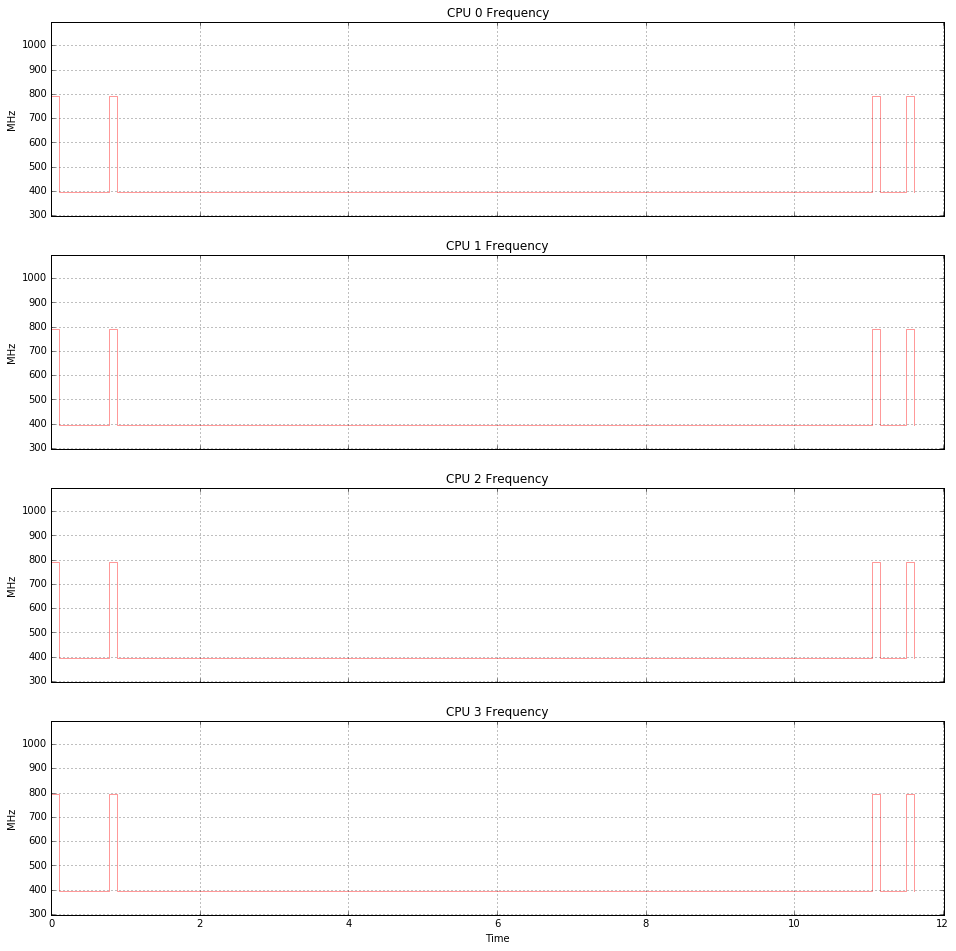

In [14]:
tr.analysis.frequency.plotCPUFrequencies()

### Plot execution

In [15]:
#tr.analysis.tasks.plotTasks()

In [16]:
df = tr.ftrace.sched_switch.data_frame
a = df[df['__comm'].str.contains('T00')][['__pid']]
pids_set=set([])
for i in a.index:
    pid = a.get_value(i, '__pid')
    #print "Adding pid ", pid
    if isinstance(pid, int):
        pids_set.add(pid)
pids_list=list(pids_set)
#print "Plotting pids: ", pids_list
trappy.plotter.plot_trace(res_dir, "", pids_list)

### Plot GRUB total bw

In [17]:
for i in range (0, cpu_number):
    try:
        trappy.ILinePlot(tr.ftrace,
                signals=[
                            "sched_dl_grub:total_bw:0x0,0x0,0xff",
                ],
                pivot="cpu_id",
                filters={"cpu_id": [i]},
                marker = '+',
                drawstyle='steps-post',
                per_line=1).view()
    except Exception, err:
        print "No data for cpu ", i, " ", err

No data for cpu  0   No plots for the given constraints
No data for cpu  1   No plots for the given constraints


""
""


No data for cpu  3   No plots for the given constraints


### Plot GRUB active bw

In [18]:
for i in range (0, cpu_number):
    try:
        trappy.ILinePlot(tr.ftrace,
                signals=[
                            "sched_dl_grub:running_bw:0x0ff,0x0,0x0",
                ],
                pivot="cpu_id",
                filters={"cpu_id": [i]},
                marker = '+',
                drawstyle='steps-post',
                per_line=1).view()
    except Exception, err:
        print "No data for cpu ", i, " ", err

No data for cpu  0   No plots for the given constraints
No data for cpu  1   No plots for the given constraints


""
""


No data for cpu  3   No plots for the given constraints


In [19]:
#df = tr.data_frame.trace_event('sched_dl_grub')

In [20]:
#trappy.BarPlot(df, column='running_bw').view()

In [21]:
#trappy.BarPlot(df, column='total_bw').view()